In [ ]:
# 思路：把数据分成两部分，一部分只有数字变量，一部分是text
# 分别进行embedding化成向量后在训练的途中结合在一起，最后求出回归的值

In [ ]:
# Training process

In [47]:
import csv
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


from verstack.stratified_continuous_split import scsplit # pip install verstack
from nltk.corpus import stopwords 

import torch
import torch.nn.functional as F

from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import os
import gensim
from gensim.models.doc2vec import Doc2Vec
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [2]:
# Load the training data
train_data = pd.read_csv("data/train.csv")
train_data.head()

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049


In [3]:
# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(["retweets_count","TweetID"], axis=1)
X_test = X_test.drop(["retweets_count","TweetID"], axis=1)

In [4]:
X_train.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp
248361,fond pouvaient passer tour réduirait risques c...,0,430,33796,528,[],['https://t.co/djoxyewgdp'],0,[],1647628404000
74899,rt mme pen intéressée élysée sauver rente élec...,0,281,4472,600,[],[],0,[],1647198793000
122170,grand charles,0,483,6222,596,[],[],0,[],1647406518000
261409,voit devient dangereux inquiétez ira réfugier ...,0,4027,210391,5000,[],['https://t.co/19y52owwdy'],0,[],1647024850000
45640,rt amateurisme sécurité veux protéger français...,0,872,13790,1243,[],[],0,[],1647124135000


In [5]:
# replace the columns of ["mentions","urls","hashtags"] by the number of their elements
def count_item(str_):
    str_=str_[1:-1]
    if (len(str_)==0):
        return 0
    list_str_=str_.split(",")
    return len(list_str_)

In [6]:
def count_num(data,list_column):
    for name_column in list_column:
        data[name_column]=[count_item(content) for content in data[name_column]]

In [7]:
count_num(X_train,["mentions","urls","hashtags"])
count_num(X_test,["mentions","urls","hashtags"])

In [8]:
X_train.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp
248361,fond pouvaient passer tour réduirait risques c...,0,430,33796,528,0,1,0,0,1647628404000
74899,rt mme pen intéressée élysée sauver rente élec...,0,281,4472,600,0,0,0,0,1647198793000
122170,grand charles,0,483,6222,596,0,0,0,0,1647406518000
261409,voit devient dangereux inquiétez ira réfugier ...,0,4027,210391,5000,0,1,0,0,1647024850000
45640,rt amateurisme sécurité veux protéger français...,0,872,13790,1243,0,0,0,0,1647124135000


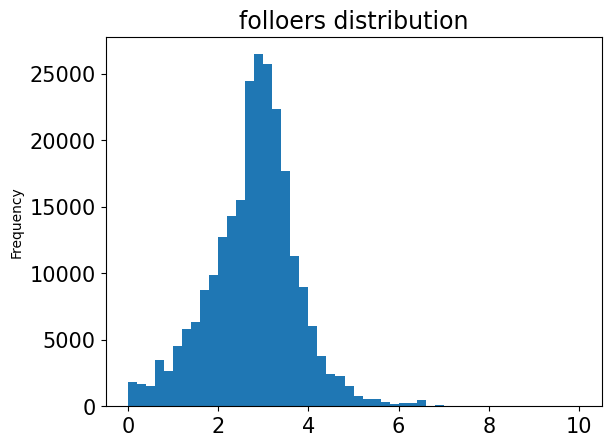

In [12]:
np.log10(X_train['followers_count']).plot.hist(bins=50,range=[0,10])
plt.tick_params(labelsize=15)
plt.title('folloers distribution', fontsize=17)
plt.show()

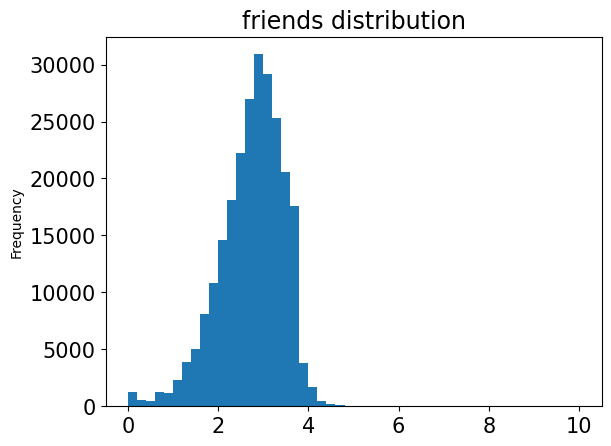

In [13]:
np.log10(X_train['friends_count']).plot.hist(bins=50,range=[0,10])
plt.tick_params(labelsize=15)
plt.title('friends distribution', fontsize=17)
plt.show()

In [14]:
# standardise the columns of numeric values
def standardise(data,list_column):
    for name_column in list_column:
        if data[name_column].std()!=0:
            data[name_column]=(data[name_column]-data[name_column].mean())/data[name_column].std()
        else:
            data[name_column]=(data[name_column]-data[name_column].mean())

In [15]:
standardise(X_train,["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"])
standardise(X_test,["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"])

In [16]:
X_test.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp
189606,article constitution procédé nouvelle dissolut...,-0.055739,-0.065147,1.901790,-0.476549,0.0,0.925575,-0.175443,-0.384052,0.086927
213943,faire confiance tyrans pareil,-0.050964,-0.075350,-0.414226,0.691358,0.0,-1.034808,-0.175443,3.480158,0.056251
163776,tweet pue gauche pourtant jsuis,-0.055739,-0.078332,-0.422332,-0.512745,0.0,-1.034808,-0.175443,-0.384052,0.142391
49651,rt partie,-0.055739,-0.062549,5.617279,1.419288,0.0,-1.034808,-0.175443,-0.384052,0.140013
163469,rt essentiel question vote blanc consiste élec...,-0.055739,-0.071335,1.490695,0.393348,0.0,-1.034808,-0.175443,-0.384052,0.122947


In [ ]:
# split the table into 2 parts: one with the text and the other with the numbers

In [17]:
X_train_num=X_train[["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"]]

X_test_num=X_test[["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"]]

X_train_num.head()

,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp
248361,-0.054351,-0.075666,-0.126647,-0.371440,0.0,0.923061,-0.176066,-0.384336,0.131178
74899,-0.054351,-0.076230,-0.383837,-0.342755,0.0,-1.039528,-0.176066,-0.384336,0.039183
122170,-0.054351,-0.075465,-0.368489,-0.344348,0.0,-1.039528,-0.176066,-0.384336,0.083664
261409,-0.054351,-0.062029,1.422207,1.410270,0.0,0.923061,-0.176066,-0.384336,0.001936
45640,-0.054351,-0.073990,-0.302112,-0.086574,0.0,-1.039528,-0.176066,-0.384336,0.023196


In [18]:
X_train_text=X_train["text"]
X_test_text=X_test["text"]
X_train_text.head()

248361    fond pouvaient passer tour réduirait risques c...
74899     rt mme pen intéressée élysée sauver rente élec...
122170                                        grand charles
261409    voit devient dangereux inquiétez ira réfugier ...
45640     rt amateurisme sécurité veux protéger français...
Name: text, dtype: object

In [19]:
# these parts are used to train the embedding of the vocabulary, only needed to be run once

In [20]:
def get_text(file):
    data_text=pd.read_table(file)
    return data_text

In [21]:
path_text_dataset='French-Word-Embeddings/Data/data.txt'
text_dataset=get_text(path_text_dataset).values
text_dataset=[item[0][:-1] for item in text_dataset]
text_dataset[:5]

['aurant la thérapie , et au niveau sexuel ',
 'pas encore  ',
 'il veut mettre fin au mariage  ',
 'je suis une mauvaise artiste  ',
 "ce cours t'a pourtant fait du bien  "]

In [22]:
TaggedDocument=gensim.models.doc2vec.TaggedDocument
def X_text(sentences):
    X=[]
    for i,text in enumerate(sentences):
        words=text.split(" ")
        l=len(words)
        words=words[:-2]
        document=TaggedDocument(words,tags=[i])
        X.append(document)
    return X

In [23]:
X_documents=X_text(text_dataset)
X_documents[:5]

[TaggedDocument(words=['aurant', 'la', 'thérapie', ',', 'et', 'au', 'niveau'], tags=[0]),
 TaggedDocument(words=['pas', 'encore'], tags=[1]),
 TaggedDocument(words=['il', 'veut', 'mettre', 'fin', 'au', 'mariage'], tags=[2]),
 TaggedDocument(words=['je', 'suis', 'une', 'mauvaise', 'artiste'], tags=[3]),
 TaggedDocument(words=['ce', 'cours', "t'a", 'pourtant', 'fait', 'du', 'bien'], tags=[4])]

In [24]:
def train_text(text_train,size=100,epochs=10):
    model=Doc2Vec(text_train,min_count=1,window=3,vector_size=size,sample=1e-3,negative=5,epochs=epochs)
    model.train(text_train,total_examples=model.corpus_count,epochs=model.epochs)
    return model

In [25]:
model_text=train_text(X_documents)
if not os.path.exists('./WE_models'):
    os.mkdir('./WE_models')
model_text.save('WE_models/d2v_100D')

KeyboardInterrupt: 

In [ ]:
# load the model

In [26]:
model_text=Doc2Vec.load('WE_models/d2v_100D')

In [27]:
def text2vec(text_train,alpha=0.05, min_alpha=0.025, epochs=10):
    list_text=[]
    for sentence in text_train:
        words=sentence.split(" ")
        vec=model_text.infer_vector(doc_words=words, alpha=alpha, min_alpha=min_alpha, epochs=epochs).tolist()
        list_text.append(vec)
    return np.array(list_text)

In [28]:
# tencor of the text part
X_train_text_vec=text2vec(X_train_text,alpha=0.05, min_alpha=0.025, epochs=10)
X_train_text_tensor=torch.Tensor(X_train_text_vec)
X_train_text_tensor

tensor([[ 0.1891, -0.1726, -0.4459,  ...,  0.1304, -0.0999, -0.0791],
        [-0.0097, -0.0274,  0.5916,  ...,  0.2240,  0.1447,  0.2191],
        [-0.0737, -0.1221,  0.3941,  ..., -0.1333,  0.1326,  0.1963],
        ...,
        [ 0.4487, -0.2816, -0.5717,  ...,  0.1426,  0.4588,  0.2127],
        [ 0.2633,  0.3057,  0.2458,  ...,  0.1410,  0.1402,  0.3589],
        [-0.2488,  0.0233, -0.4455,  ...,  0.1203, -0.1075,  0.1437]])

In [29]:
X_train_text_tensor[0]

tensor([ 0.1891, -0.1726, -0.4459, -0.6369, -0.1092,  0.4852, -0.0977,  0.2108,
         0.2050,  0.1604,  0.3494,  0.2966, -0.1630, -0.2043, -0.1326, -0.3242,
        -0.0978,  0.1337,  0.5905, -0.0138, -0.3458,  0.0818, -0.3403, -0.2796,
         0.2571,  0.6421,  0.0553, -0.2078, -0.0721, -0.0134,  0.3456,  0.2033,
        -0.2690, -0.0409, -0.2929, -0.1682, -0.2576, -0.0255,  0.0314, -0.2966,
        -0.1660, -0.4310,  0.3253, -0.0348,  0.5358,  0.0649,  0.2638, -0.0198,
        -0.1067,  0.5373,  0.0603,  0.2641,  0.0008, -0.3681,  0.2414, -0.1848,
        -0.0776,  0.0448,  0.2742, -0.3375, -0.0438, -0.0858,  0.5241,  0.1783,
         0.1783,  0.1135,  0.2864, -0.0883, -0.4336,  0.1020,  0.0168, -0.0649,
         0.1552,  0.4201, -0.2344,  0.4878,  0.2410, -0.1763, -0.0793,  0.0391,
        -0.1663, -0.1868, -0.4253, -0.2348,  0.1645, -0.3233,  0.0257, -0.0886,
        -0.4830, -0.5818,  0.3695, -0.2037, -0.4331, -0.2452,  0.3438,  0.0239,
         0.0021,  0.1304, -0.0999, -0.07

In [30]:
X_test_text_vec=text2vec(X_test_text,alpha=0.05, min_alpha=0.025, epochs=10)
X_test_text_tensor=torch.Tensor(X_test_text_vec)
X_test_text_tensor

tensor([[ 1.9678e-01,  1.3962e-01, -1.2011e-01,  ...,  2.3719e-02,
         -1.0452e-01,  1.3548e-01],
        [ 1.0742e-02,  3.6920e-01, -1.6959e-01,  ...,  8.3528e-02,
          1.0783e-01, -3.9078e-01],
        [ 2.3560e-01, -6.0289e-02, -1.5973e-01,  ...,  2.7903e-02,
          1.9778e-01, -1.8797e-02],
        ...,
        [-1.4762e-01,  1.8328e-01, -4.7985e-02,  ...,  4.6532e-03,
          5.4372e-02, -1.3120e-01],
        [ 6.8037e-01,  2.8168e-01, -4.2375e-01,  ...,  1.9363e-01,
          2.4726e-02, -1.3919e-01],
        [ 4.2878e-03,  2.3877e-03, -4.7562e-03,  ...,  4.4457e-03,
         -3.9348e-03, -5.3238e-04]])

In [31]:
# tensor of the numeric part
X_train_num_vec=X_train_num.values
X_train_num_tensor=torch.Tensor(X_train_num_vec)
X_test_num_vec=X_test_num.values
X_test_num_tensor=torch.Tensor(X_test_num_vec)

In [32]:
y_train_tensor=torch.Tensor(y_train.to_numpy())
y_train_tensor=y_train_tensor.reshape((-1,1))
y_test_tensor=torch.Tensor(y_test.to_numpy())
y_test_tensor=y_test_tensor.reshape((-1,1))

In [33]:
dataset_XY = torch.utils.data.TensorDataset(X_train_num_tensor,X_train_text_tensor, y_train_tensor)
testset_XY = torch.utils.data.TensorDataset(X_test_num_tensor, X_test_text_tensor, y_test_tensor)

In [ ]:
# ML methods

In [35]:
X_train_num_vec.shape

(247778, 9)

In [37]:
X_train_text_vec.shape

(247778, 100)

In [38]:
def MAE(pred,real):
    N=len(pred)
    sum=0
    for i in range(N):
        sum+=abs(pred[i]-real[i])
    return sum/N

In [45]:
def ACC(pred,real):
    N=len(pred)
    sum=0
    for i in range(N):
        if pred[i]==real[i]:
            sum+=1
    return sum/N

In [40]:
X_train_vec=np.hstack([X_train_text_vec,X_train_num_vec])
X_train_vec.shape

(247778, 109)

In [48]:
X_test_vec=np.hstack([X_test_text_vec,X_test_num_vec])
X_test_vec.shape

(106191, 109)

In [49]:
y_test_vec=np.array(y_test).reshape((-1,1))
y_test_vec.shape

(106191, 1)

In [51]:
def model_result(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array([int(value) if value >= 0 else 0 for value in y_pred])
    loss=MAE(y_pred,y_test)
    acc=ACC(y_pred,y_test)
    return loss,acc

In [54]:
model_Lasso=Lasso(alpha=0.1)
loss_Lasso,acc_Lasso=model_result(model_Lasso,X_train_vec,y_train_vec,X_test_vec,y_test_vec)

In [55]:
loss_Lasso

array([9.67214736])

In [56]:
acc_Lasso

0.30940475181512556

In [ ]:
model_Knn=KNeighborsRegressor(n_neighbors=3)
loss_Knn,acc_Knn=model_result(model_Knn,X_train_vec,y_train_vec,X_test_vec,y_test_vec)

In [ ]:
loss_Knn

In [ ]:
acc_Knn

In [ ]:
# build the net 这里开始要改的

In [98]:
class RegressionNet(torch.nn.Module):
    def __init__(self, height, width_num, width_text):
        super(RegressionNet, self).__init__()
        self.layer_num = torch.nn.Linear(height*width_num, height)
        self.layer_text = torch.nn.Linear(height*width_text, height)
        self.predict=torch.nn.Linear(height*2, height)
    def forward(self, x_num,x_text):
        x_num=x_num.flatten()
        x_num=self.layer_num(x_num)
        x_num = F.relu(x_num)
        x_text=x_text.flatten()
        x_text=self.layer_text(x_text)
        x_text = F.relu(x_text)
        x_tot=torch.concat([x_num,x_text])
        x_tot=self.predict(x_tot)
        # x_tot=x_tot.int()
        return x_tot

In [100]:
batch_size=16

In [101]:
# 就取一小部分试试能不能跑，真用的时候记得把batch去掉
dataset_XY_batch = torch.utils.data.TensorDataset(X_train_num_tensor[:batch_size*10],X_train_text_tensor[:batch_size*10], y_train_tensor[:batch_size*10])
testset_XY_batch = torch.utils.data.TensorDataset(X_test_num_tensor[:batch_size*10], X_test_text_tensor[:batch_size*10], y_test_tensor[:batch_size*10])

In [103]:
RNet=RegressionNet(batch_size,X_train_num_tensor.shape[1],X_train_text_tensor.shape[1])

In [104]:
def trainer(data_train,model,loss_fn,epoch=100,batch_size=16,rate=1e-3):
    optimiser=torch.optim.Adam(model.parameters(),lr=rate)
    loader_train=torch.utils.data.DataLoader(dataset=data_train,batch_size=batch_size,shuffle=True)
    for i in range(epoch):
        print("epoch "+str(i))
        for step,(batch_x_num,batch_x_text,batch_y) in enumerate(loader_train):    
            #print(batch_x.float())
            pred=model(batch_x_num,batch_x_text)
            #class_pred = torch.argmax(pred,dim = -1)
            loss=loss_fn(pred,batch_y)  
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            if (step%1000==0):
                print("now training step "+str(step))
                print(loss)

In [105]:
trainer(dataset_XY_batch,RNet,MAE,epoch=100,batch_size=batch_size,rate=1e-3)

epoch 0
now training step 0
tensor([59.8015], grad_fn=<DivBackward0>)
epoch 1
now training step 0
tensor([1.9746], grad_fn=<DivBackward0>)
epoch 2
now training step 0
tensor([1.3338], grad_fn=<DivBackward0>)
epoch 3
now training step 0
tensor([3.6518], grad_fn=<DivBackward0>)
epoch 4
now training step 0
tensor([9.1199], grad_fn=<DivBackward0>)
epoch 5
now training step 0
tensor([61.1826], grad_fn=<DivBackward0>)
epoch 6
now training step 0
tensor([1.5609], grad_fn=<DivBackward0>)
epoch 7
now training step 0
tensor([30.8284], grad_fn=<DivBackward0>)
epoch 8
now training step 0
tensor([59.1662], grad_fn=<DivBackward0>)
epoch 9
now training step 0
tensor([2.2391], grad_fn=<DivBackward0>)
epoch 10
now training step 0
tensor([1.7707], grad_fn=<DivBackward0>)
epoch 11
now training step 0
tensor([9.7797], grad_fn=<DivBackward0>)
epoch 12
now training step 0
tensor([1.6283], grad_fn=<DivBackward0>)
epoch 13
now training step 0
tensor([1.1649], grad_fn=<DivBackward0>)
epoch 14
now training step

In [120]:
def success_rate(model,loss_fn,batch_size,test_data):
    loader_test=torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True)
    total=0
    total_loss=0
    for step,(batch_x_num,batch_x_text,batch_y) in enumerate(loader_test):    
            #print(batch_x.float())
        pred=model(batch_x_num,batch_x_text)
            #class_pred = torch.argmax(pred,dim = -1)
        loss=loss_fn(pred,batch_y)  
        total_loss+=loss
        for i in range(len(pred)):
            if int(pred[i])==int(batch_y[i]):
                total+=1
        # 应该要把预测结果都变成int的，但这样可能产生预测结果全是0，求不了梯度不能反向传播了，要想个办法
    return total/len(test_data),total_loss

In [121]:
# 屎一样的准确率和误差
accuracy,MAE_loss=success_rate(RNet,MAE,batch_size,testset_XY_batch)
print(accuracy)
print(MAE_loss)

0.24375
tensor([135.0616], grad_fn=<AddBackward0>)


In [ ]:
# start evaluation

In [132]:
X_eval = pd.read_csv("data/evaluation.csv")
X_eval.head()

,text,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,descendue pourcentage vote,0,85,4442,327,[],[],0,"['presidentielle2022', 'hidalgo']",1647607994000,1184643
1,photo demande arbre généalogique,0,427,33282,443,[],[],0,[],1647601275000,1199190
2,dossiers promis poste gars vraiment fiable,6,1127,13111,1596,[],[],0,['macron'],1646900684000,917372
3,lol cas faut second tour macron sortir définit...,2,1699,25760,2036,[],['https://t.co/7ox54d8dlm'],0,[],1647161294000,731754
4,zemmour putain discours propagandiste littéral...,0,249,20718,369,[],"['https://t.co/tsw9cg6v9j', 'https://t.co/t0j9...",0,[],1647724874000,1400049


In [133]:
count_num(X_eval,["mentions","urls","hashtags"])
standardise(X_eval,["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"])

In [134]:
X_eval_num=X_eval[["favorites_count","followers_count","statuses_count","friends_count","mentions","urls","verified","hashtags","timestamp"]]
X_eval_text=X_eval["text"]

In [135]:
X_eval_text_vec=text2vec(X_eval_text,alpha=0.05, min_alpha=0.025, epochs=10)
X_eval_text_tensor=torch.Tensor(X_eval_text_vec)
X_eval_text_tensor

tensor([[ 0.1203,  0.0341, -0.0505,  ..., -0.0175, -0.1900,  0.4095],
        [-0.0866,  0.0757,  0.1707,  ...,  0.0975,  0.0957, -0.1442],
        [ 0.5045,  0.3030, -0.5510,  ...,  0.0991,  0.2207,  0.1374],
        ...,
        [ 0.1202, -0.0215,  0.4697,  ..., -0.4211,  0.1100,  0.2946],
        [ 0.4166,  0.6918, -0.1486,  ...,  0.4981, -0.0503,  0.5017],
        [-0.1856,  0.1329,  0.0368,  ...,  0.0999, -0.1310,  0.2792]])

In [136]:
X_eval_num_vec=X_eval_num.values
X_eval_num_tensor=torch.Tensor(X_eval_num_vec)

In [148]:
dataset_eval = torch.utils.data.TensorDataset(X_eval_num_tensor,X_eval_text_tensor)
dataset_eval_batch = torch.utils.data.TensorDataset(X_eval_num_tensor[:batch_size*10],X_eval_text_tensor[:batch_size*10])

In [165]:
def evaluate(model,batch_size,test_eval):
    res=[]
    loader_eval=torch.utils.data.DataLoader(dataset=test_eval,batch_size=batch_size,shuffle=True)
    for step,(batch_x_num,batch_x_text) in enumerate(loader_eval):    
            #print(batch_x.float())
        pred=model(batch_x_num,batch_x_text)
            #class_pred = torch.argmax(pred,dim = -1)
        for i in range(len(pred)):
            res.append(float(pred[i]))
        if (step%10==0):
                print("now training step "+str(step))
    return res

In [166]:
evaluations=evaluate(RNet,batch_size,dataset_eval_batch)

now training step 0


In [168]:
evaluations[:5]

[1.171513319015503,
 1.0925911664962769,
 0.6914440989494324,
 0.9591779112815857,
 1.405458688735962]

In [169]:
with open("my_predictions.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "retweets_count"])
    for index, prediction in enumerate(evaluations):
        writer.writerow([str(X_eval['TweetID'].iloc[index]) , str(int(prediction))])